Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for MSFT...
Fetching data for GOOGL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for AMZN...
Fetching data for TSLA...


[*********************100%***********************]  1 of 1 completed


Preprocessing data for AAPL...
Preprocessing data for MSFT...
Preprocessing data for GOOGL...
Preprocessing data for AMZN...
Preprocessing data for TSLA...


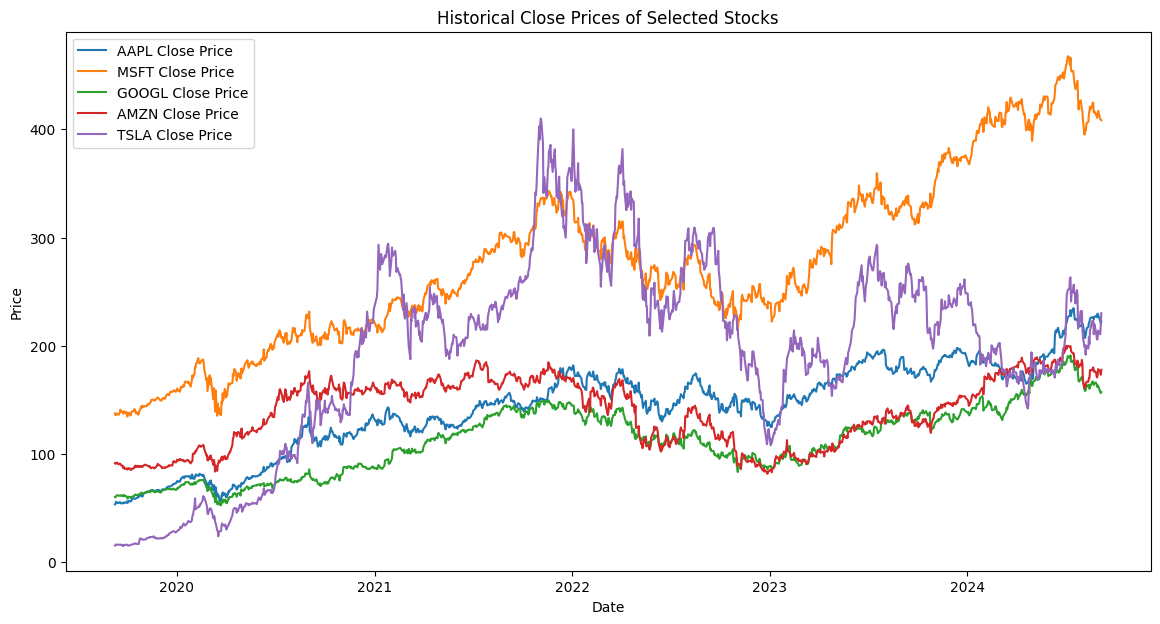

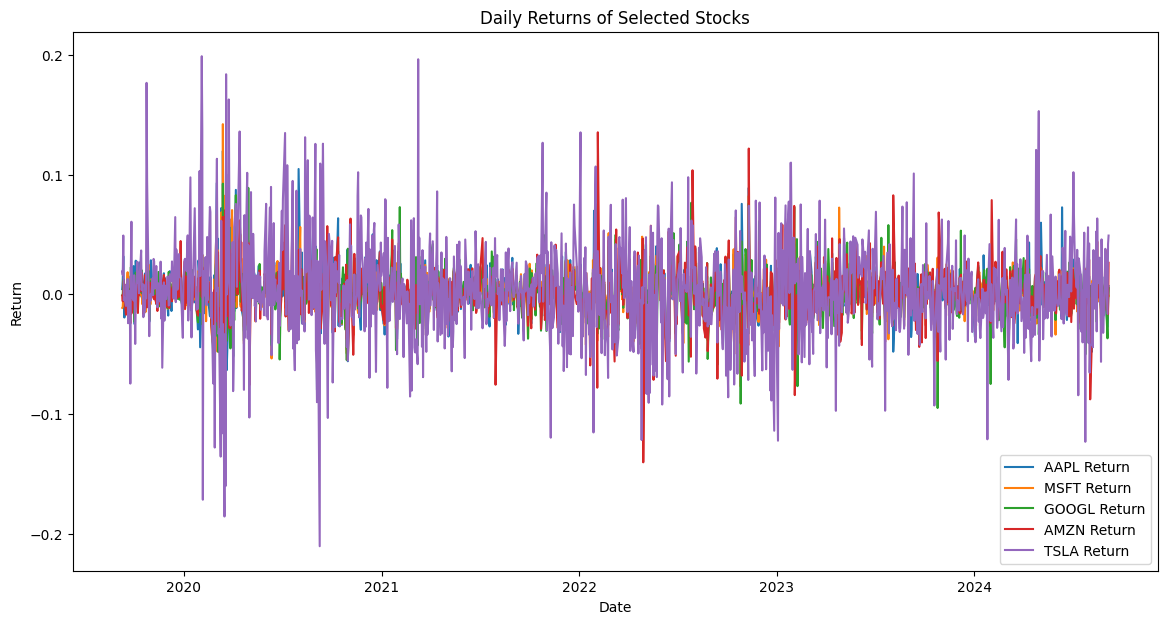

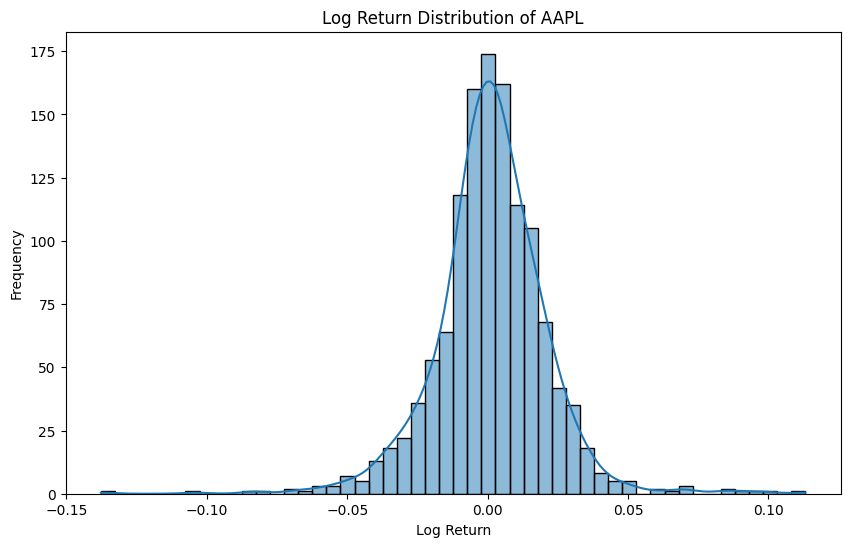

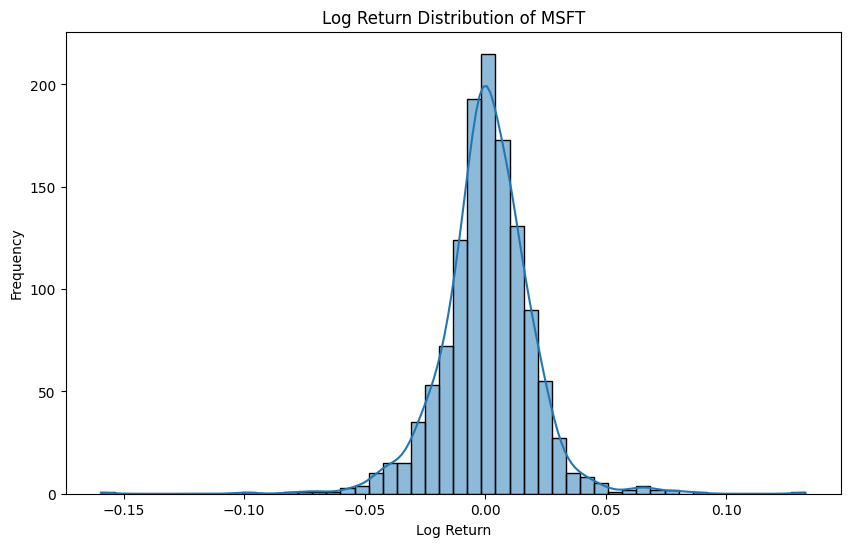

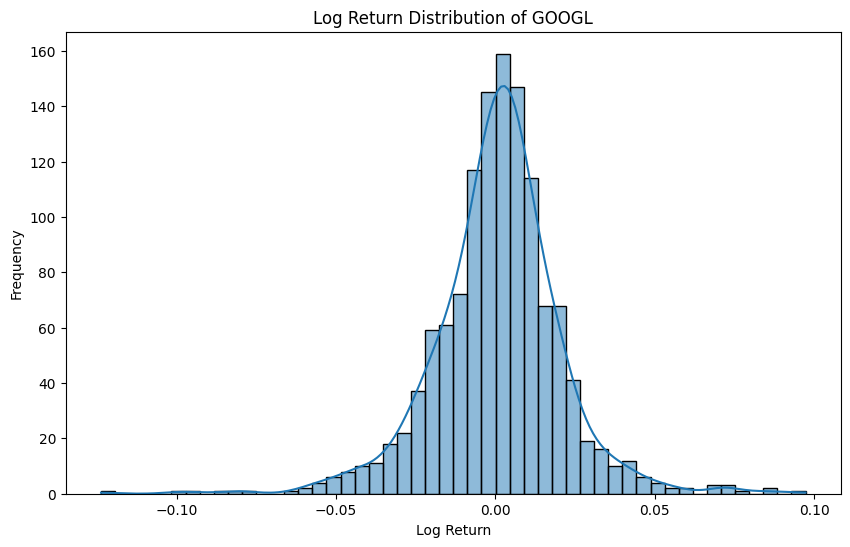

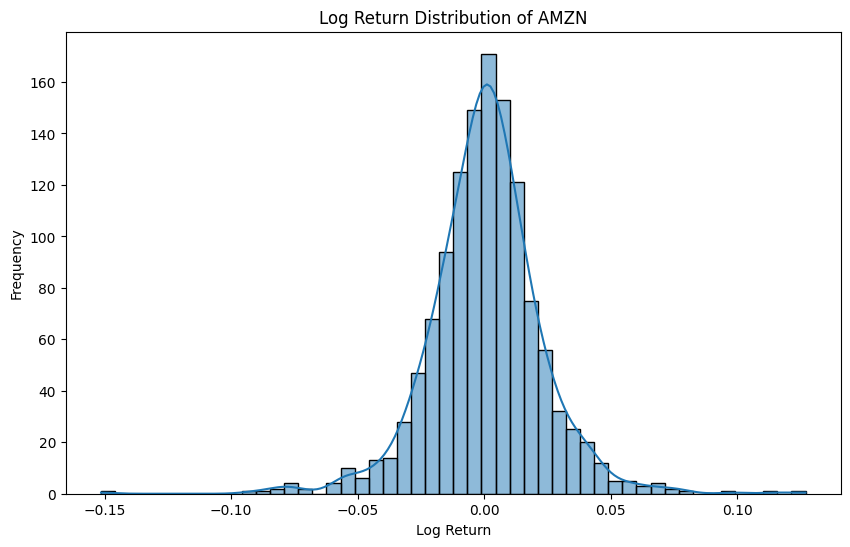

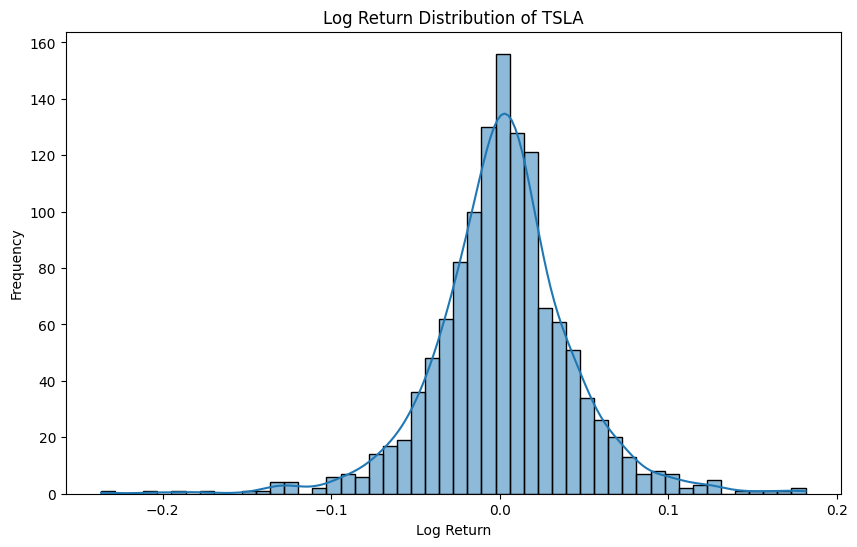

Statistics for AAPL:
  Mean Return: 0.0013
  Volatility: 0.0200
  Mean Log Return: 0.0011
  Log Volatility: 0.0200
  Annualized Volatility: 0.3170
Statistics for MSFT:
  Mean Return: 0.0010
  Volatility: 0.0191
  Mean Log Return: 0.0009
  Log Volatility: 0.0191
  Annualized Volatility: 0.3029
Statistics for GOOGL:
  Mean Return: 0.0010
  Volatility: 0.0201
  Mean Log Return: 0.0008
  Log Volatility: 0.0201
  Annualized Volatility: 0.3195
Statistics for AMZN:
  Mean Return: 0.0008
  Volatility: 0.0223
  Mean Log Return: 0.0005
  Log Volatility: 0.0223
  Annualized Volatility: 0.3548
Statistics for TSLA:
  Mean Return: 0.0030
  Volatility: 0.0414
  Mean Log Return: 0.0022
  Log Volatility: 0.0414
  Annualized Volatility: 0.6574
Evaluating Decision Tree for AAPL...
Decision Tree for AAPL - MSE (Train): 0.3166, MSE (Test): 13.2797
Evaluating Decision Tree for MSFT...
Decision Tree for MSFT - MSE (Train): 0.2585, MSE (Test): 52.8388
Evaluating Decision Tree for GOOGL...
Decision Tree for GO

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

# Step 1: Fetch and preprocess data for multiple stocks
def fetch_data(tickers, period="5y", interval="1d"):
    stock_data = {}
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        stock_data[ticker] = yf.download(ticker, period=period, interval=interval)
    return stock_data

def preprocess_data(stock_data):
    for ticker in stock_data:
        print(f"Preprocessing data for {ticker}...")
        stock_data[ticker] = stock_data[ticker].dropna()
        stock_data[ticker]['Return'] = stock_data[ticker]['Close'].pct_change()
        stock_data[ticker]['Log_Return'] = np.log(stock_data[ticker]['Close'] / stock_data[ticker]['Close'].shift(1))
        stock_data[ticker] = stock_data[ticker].dropna()
    return stock_data

# Step 2: Visualize the data
def visualize_data(stock_data):
    plt.figure(figsize=(14, 7))
    for ticker in stock_data:
        plt.plot(stock_data[ticker]['Close'], label=f'{ticker} Close Price')
    plt.title('Historical Close Prices of Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot each stock's returns
    plt.figure(figsize=(14, 7))
    for ticker in stock_data:
        plt.plot(stock_data[ticker]['Return'], label=f'{ticker} Return')
    plt.title('Daily Returns of Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    # Plot histograms of log returns
    for ticker in stock_data:
        plt.figure(figsize=(10, 6))
        sns.histplot(stock_data[ticker]['Log_Return'], bins=50, kde=True)
        plt.title(f'Log Return Distribution of {ticker}')
        plt.xlabel('Log Return')
        plt.ylabel('Frequency')
        plt.show()

# Step 3: Calculate additional statistics
def calculate_statistics(stock_data):
    stats = {}
    for ticker in stock_data:
        stats[ticker] = {
            'Mean Return': stock_data[ticker]['Return'].mean(),
            'Volatility': stock_data[ticker]['Return'].std(),
            'Mean Log Return': stock_data[ticker]['Log_Return'].mean(),
            'Log Volatility': stock_data[ticker]['Log_Return'].std(),
            'Annualized Volatility': stock_data[ticker]['Return'].std() * np.sqrt(252)
        }
        print(f"Statistics for {ticker}:")
        for key, value in stats[ticker].items():
            print(f"  {key}: {value:.4f}")
    return stats

# Step 4: Cluster Analysis for grouping similar performance stocks
def cluster_analysis(stock_data, n_clusters=3):
    returns = pd.DataFrame({ticker: stock_data[ticker]['Return'] for ticker in stock_data})
    log_returns = pd.DataFrame({ticker: stock_data[ticker]['Log_Return'] for ticker in stock_data})

    # Scaling both regular and log returns
    scaler = StandardScaler()
    returns_scaled = scaler.fit_transform(returns)
    log_returns_scaled = scaler.fit_transform(log_returns)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(returns_scaled)
    log_clusters = kmeans.fit_predict(log_returns_scaled)

    returns['Cluster'] = clusters
    log_returns['Cluster'] = log_clusters

    # Add cluster info to each stock's data for visualization
    for i, ticker in enumerate(stock_data):
        stock_data[ticker]['Cluster'] = clusters[i]
        stock_data[ticker]['Log_Cluster'] = log_clusters[i]

    return returns, log_returns

# Step 5: Decision Tree for Stock Price Prediction
def decision_tree_efficiency(stock_data):
    results = {}

    for ticker in stock_data:
        print(f"Evaluating Decision Tree for {ticker}...")
        # Prepare data for regression (features are previous day's close prices)
        X = stock_data[ticker]['Close'].shift(1).dropna().values.reshape(-1, 1)
        y = stock_data[ticker]['Close'][1:]  # Actual prices (target)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train Decision Tree Regressor
        model = DecisionTreeRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate Mean Squared Error (MSE) for training and testing data
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)

        results[ticker] = {
            'MSE_Train': mse_train,
            'MSE_Test': mse_test
        }

        print(f"Decision Tree for {ticker} - MSE (Train): {mse_train:.4f}, MSE (Test): {mse_test:.4f}")

    return results

# Step 6: Cluster Analysis Evaluation
def cluster_analysis_efficiency(stock_data, n_clusters=3):
    returns = pd.DataFrame({ticker: stock_data[ticker]['Return'] for ticker in stock_data}).dropna()
    scaler = StandardScaler()
    returns_scaled = scaler.fit_transform(returns)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(returns_scaled)

    # Calculate Inertia and Silhouette Score for clustering evaluation
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(returns_scaled, clusters)

    print(f"Cluster Analysis - Inertia: {inertia:.4f}, Silhouette Score: {silhouette_avg:.4f}")

    return {
        'Inertia': inertia,
        'Silhouette Score': silhouette_avg
    }

# Example usage:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']  # List of 5 stocks
stock_data = fetch_data(tickers, period="5y", interval="1d")
stock_data = preprocess_data(stock_data)

visualize_data(stock_data)

stats = calculate_statistics(stock_data)

returns, log_returns = cluster_analysis(stock_data, n_clusters=3)

# Step 7: Evaluate Decision Trees
decision_tree_results = decision_tree_efficiency(stock_data)

# Step 8: Evaluate Cluster Analysis
cluster_results = cluster_analysis_efficiency(stock_data, n_clusters=3)

# Print results
print("\nDecision Tree Results:")
for ticker, result in decision_tree_results.items():
    print(f"{ticker} - MSE Train: {result['MSE_Train']:.4f}, MSE Test: {result['MSE_Test']:.4f}")

print("\nCluster Analysis Results:")
print(f"Inertia: {cluster_results['Inertia']:.4f}, Silhouette Score: {cluster_results['Silhouette Score']:.4f}")
